View the Time series providing Article ID

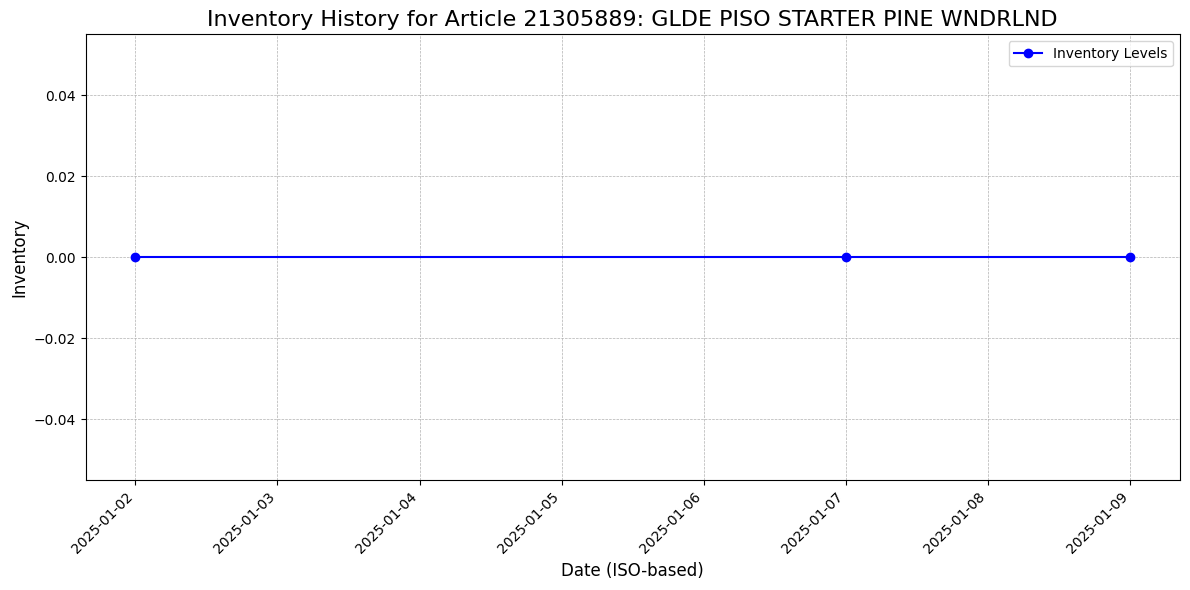

In [9]:
#!/usr/bin/env python3
# iso_based_timeseries.py

import psycopg2
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import matplotlib.dates as mdates
import json

# ------------------------------------------------------------------------------
# 1. Database configuration
# ------------------------------------------------------------------------------
db_config = json.load(open('config.json'))
# ------------------------------------------------------------------------------
# 2. Convert (ISO year, ISO week, ISO day=1..7) to a date
# ------------------------------------------------------------------------------
def iso_to_date(iso_year: int, iso_week: int, iso_day: int) -> date:
    """
    Convert an ISO year-week-day combination (e.g. 2025, 2, 2)
    into a Python date object (2025-01-07).

      - iso_year: The ISO-8601 year (which can differ from calendar year near boundaries).
      - iso_week: The ISO week number (1..53).
      - iso_day:  1=Monday .. 7=Sunday (ISO-8601).

    Returns:
        A datetime.date object representing the actual (Gregorian) date.
    """
    # Step 1: January 4 is always in ISO week 1.
    january_4 = date(iso_year, 1, 4)

    # Step 2: Find Monday of ISO week 1
    #   isoweekday() => Monday=1, Tuesday=2, ..., Sunday=7.
    #   Subtract (january_4.isoweekday() - 1) days to get that Monday.
    first_monday = january_4 - timedelta(days=january_4.isoweekday() - 1)

    # Step 3: From that Monday, move forward (iso_week - 1) weeks
    #         plus (iso_day - 1) days.
    return first_monday + timedelta(weeks=(iso_week - 1), days=(iso_day - 1))

# ------------------------------------------------------------------------------
# 3. Fetch time-series data from PostgreSQL
# ------------------------------------------------------------------------------
def fetch_time_series(article_id, start_week, end_week):
    """
    Fetches inventory data from the database for the specified article
    and week range. Returns (rows, product_description, article_id).

    Each row in 'rows' will look like:
      (year, week, D0, D1, D2, D3, D4, D5, D6)
    where D0 is Monday’s inventory, D6 is Sunday’s.
    """
    conn = None
    try:
        conn = psycopg2.connect(
            host=db_config['host'],
            dbname=db_config['dbname'],
            user=db_config['user'],
            password=db_config['password'],
            port=db_config['port']
        )
        cur = conn.cursor()

        # 1) Fetch product description
        cur.execute(
            "SELECT description FROM Products WHERE article_number = %s",
            (article_id,)
        )
        description_result = cur.fetchone()
        if not description_result:
            print(f"No product found for Article ID: {article_id}")
            return None, None, None
        product_description = description_result[0]

        # 2) Fetch time-series data
        sql_query = """
        SELECT DC.year, DC.week, DC.D0_inventory, DC.D1_inventory, DC.D2_inventory,
               DC.D3_inventory, DC.D4_inventory, DC.D5_inventory, DC.D6_inventory
        FROM DailyCheckIn AS DC
        JOIN Products AS P ON DC.product_id = P.id
        WHERE P.article_number = %s
          AND DC.week >= %s
          AND DC.week <= %s
        ORDER BY DC.year, DC.week
        """
        cur.execute(sql_query, (article_id, start_week, end_week))
        rows = cur.fetchall()

        return rows, product_description, article_id

    except psycopg2.Error as e:
        print(f"Database error: {e}")
        return None, None, None
    finally:
        if conn:
            conn.close()

# ------------------------------------------------------------------------------
# 4. Plot the time series (using iso_to_date)
# ------------------------------------------------------------------------------
def plot_time_series(rows, product_description, article_id):
    """
    rows is a list of tuples: (iso_year, iso_week, D0, D1, D2, D3, D4, D5, D6)
      where D0 corresponds to Monday's inventory (iso_day=1),
      D1 => Tuesday (iso_day=2), etc.

    We'll:
      1) Convert each non-None inventory to (date, inventory).
      2) Sort by date.
      3) Plot, deciding on daily vs. weekly labeling based on total days spanned.
    """
    if not rows:
        print("No data to plot.")
        return

    all_dates = []
    all_inventories = []

    # Convert each row to potential 7 daily data points
    for (yr, wk, D0, D1, D2, D3, D4, D5, D6) in rows:
        daily_invs = [D0, D1, D2, D3, D4, D5, D6]
        for day_num, inv in enumerate(daily_invs):
            if inv is None:
                continue
            # day_num=0 => Monday => iso_day=1
            # day_num=1 => Tuesday => iso_day=2
            iso_day = day_num + 1  # map 0..6 -> 1..7
            dt = iso_to_date(yr, wk, iso_day)
            all_dates.append(dt)
            all_inventories.append(inv)

    if not all_dates:
        print("No valid data to plot after filtering None.")
        return

    # Sort by the date
    paired = sorted(zip(all_dates, all_inventories), key=lambda x: x[0])
    plot_dates, plot_values = zip(*paired)

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(plot_dates, plot_values, marker='o', linestyle='-', color='blue',
            label="Inventory Levels")

    ax.set_title(f"Inventory History for Article {article_id}: {product_description}", fontsize=16)
    ax.set_xlabel("Date (ISO-based)", fontsize=12)
    ax.set_ylabel("Inventory", fontsize=12)

    # Decide daily vs. weekly tick labeling based on total range
    day_span = (plot_dates[-1] - plot_dates[0]).days
    if day_span <= 14:
        # Label every day
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    else:
        # Label weekly (on Mondays) or use AutoDateLocator
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Grid lines
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 5. Example usage (adjust article_id, start_week, end_week as needed)
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    article_id = "21305889"
    start_week = 0
    end_week = 2

    rows, description, article_id = fetch_time_series(article_id, start_week, end_week)
    plot_time_series(rows, description, article_id)


Retreving Data Using Pytorch

In [ ]:
import psycopg2
import pandas as pd
import torch

# Database configuration
b_config = json.load(open('config.json'))
# Query to fetch data
query = """
SELECT 
    P.article_number,
    P.category,
    P.department,
    DC.d0_inventory,
    DC.d1_inventory,
    DC.d2_inventory,
    DC.d3_inventory,
    DC.d4_inventory,
    DC.d5_inventory,
    DC.d6_inventory
FROM 
    public.dailycheckin DC
JOIN 
    public.products P
ON 
    P.id = DC.product_id
ORDER BY 
    P.article_number, DC.year, DC.week;
"""

# Fetch data from PostgreSQL
def fetch_data_from_db():
    conn = psycopg2.connect(**db_config)
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# Map categories and departments to IDs
def create_mappings(df):
    category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
    department_mapping = {dept: idx for idx, dept in enumerate(df['department'].unique())}
    product_mapping = {prod: idx for idx, prod in enumerate(df['article_number'].unique())}
    return product_mapping, category_mapping, department_mapping

# Convert data to PyTorch tensors
def prepare_tensors(df, product_mapping, category_mapping, department_mapping):
    # Map product, category, and department to indices
    df['product_id'] = df['article_number'].map(product_mapping)
    df['category_id'] = df['category'].map(category_mapping)
    df['department_id'] = df['department'].map(department_mapping)

    # Prepare feature matrix (inventory columns)
    inventory_features = df[['d0_inventory', 'd1_inventory', 'd2_inventory', 
                              'd3_inventory', 'd4_inventory', 'd5_inventory', 
                              'd6_inventory']].fillna(0).values

    # Convert to tensors
    inventory_features_tensor = torch.tensor(inventory_features, dtype=torch.float)
    product_ids_tensor = torch.tensor(df['product_id'].values, dtype=torch.long)
    category_ids_tensor = torch.tensor(df['category_id'].values, dtype=torch.long)
    department_ids_tensor = torch.tensor(df['department_id'].values, dtype=torch.long)

    return inventory_features_tensor, product_ids_tensor, category_ids_tensor, department_ids_tensor

# Main function to fetch and process data
def main():
    print("Fetching data from database...")
    df = fetch_data_from_db()
    print(f"Data fetched. Total rows: {len(df)}")

    # Create mappings for product, category, and department
    product_mapping, category_mapping, department_mapping = create_mappings(df)

    # Prepare tensors
    inventory_features, product_ids, category_ids, department_ids = prepare_tensors(
        df, product_mapping, category_mapping, department_mapping
    )
    print("Data converted to tensors.")
    print(f"Inventory Features Tensor Shape: {inventory_features.shape}")
    print(f"Product IDs Tensor Shape: {product_ids.shape}")
    print(f"Category IDs Tensor Shape: {category_ids.shape}")
    print(f"Department IDs Tensor Shape: {department_ids.shape}")

    return inventory_features, product_ids, category_ids, department_ids

if __name__ == "__main__":
    inventory_features, product_ids, category_ids, department_ids = main()


In [11]:
import psycopg2
import json

def fetch_weeks_for_product(product_id, week_list):
    """
    Fetch and print data for specific weeks for a given product ID using psycopg2.

    Args:
        config_file (str): Path to the JSON configuration file for the database.
        product_id (int): The product ID to filter by.
        week_list (list): A list of week numbers to fetch data for.
    """
    try:
        # Load database configuration from JSON file
        db_config = json.load(open('config.json'))
        
        # Connect to the PostgreSQL database
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor()
        
        # Build query for the specific weeks
        week_placeholders = ', '.join(['%s'] * len(week_list))
        sql_query = f"""
        SELECT DC.year, DC.week, DC.D0_inventory, DC.D1_inventory, DC.D2_inventory,
               DC.D3_inventory, DC.D4_inventory, DC.D5_inventory, DC.D6_inventory
        FROM DailyCheckIn AS DC
        JOIN Products AS P ON DC.product_id = P.id
        WHERE P.article_number = %s
          AND DC.week IN ({week_placeholders})
        ORDER BY DC.year, DC.week
        """
        
        # Execute the query
        cursor.execute(sql_query, [product_id] + week_list)
        
        # Fetch and print results
        results = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]  # Get column names
        for row in results:
            print(dict(zip(columns, row)))
    
    except psycopg2.Error as err:
        print(f"Error: {err}")
    finally:
        if connection:
            cursor.close()
            connection.close()

# Example usage
if __name__ == "__main__":
    product_id = '21305889'
    week_list = [0,1, 2, 3, 4]
    fetch_weeks_for_product(product_id, week_list)


{'year': 2025, 'week': 1, 'd0_inventory': None, 'd1_inventory': None, 'd2_inventory': None, 'd3_inventory': 0.0, 'd4_inventory': None, 'd5_inventory': None, 'd6_inventory': None}
{'year': 2025, 'week': 2, 'd0_inventory': None, 'd1_inventory': 0.0, 'd2_inventory': None, 'd3_inventory': 0.0, 'd4_inventory': None, 'd5_inventory': None, 'd6_inventory': None}
